# Disaster Tweets Classification
This notebook tackles the Kaggle NLP competition: **Natural Language Processing with Disaster Tweets**.
We classify whether a tweet refers to a real disaster. Our approach includes EDA, preprocessing, TF-IDF vectorization, logistic regression modeling, and F1-based evaluation.

## Problem Statement
The goal is to classify tweets as either reporting real disasters or not. This is a binary classification problem in the domain of Natural Language Processing (NLP).

### Dataset Overview
- **Train set**: 7,613 tweets
- **Test set**: 3,263 tweets
- Columns: `id`, `text`, `keyword`, `location`, `target`
- `target` is the label: 1 = disaster, 0 = not disaster

In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score
sns.set(style='whitegrid')

## Load Data

In [79]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


## Exploratory Data Analysis (EDA)
- We explored the target label distribution, tweet length, keyword frequency, and locations.
- We also generated word clouds for disaster vs non-disaster tweets.


## EDA: Class Distribution and Text Characteristics

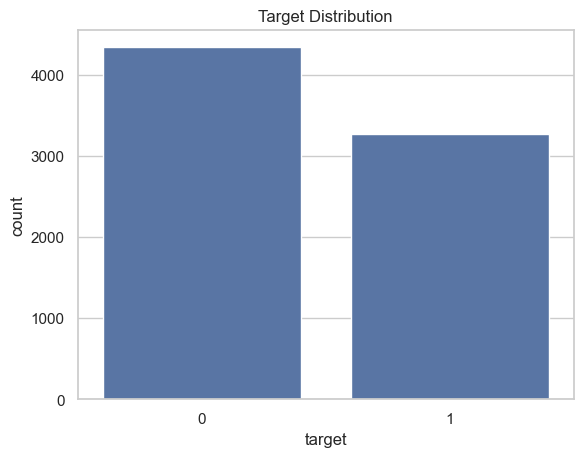

In [83]:
sns.countplot(x='target', data=train_df)
plt.title('Target Distribution')
plt.show()

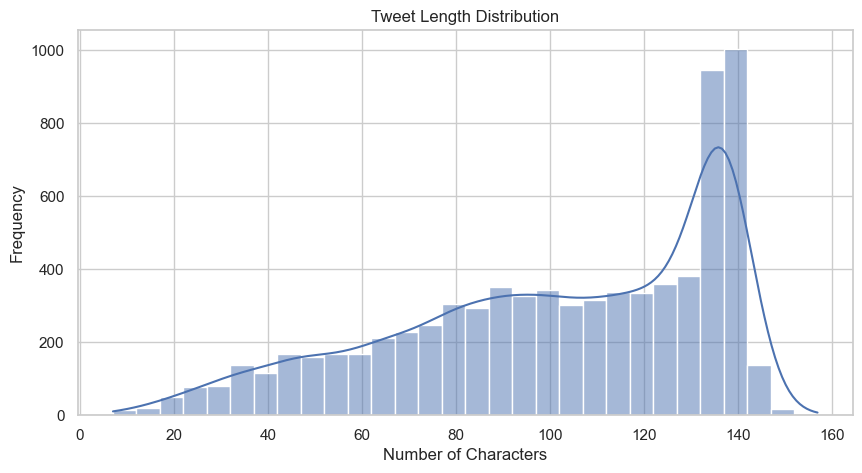

In [85]:
train_df['text_length'] = train_df['text'].apply(len)
plt.figure(figsize=(10, 5))
sns.histplot(train_df['text_length'], bins=30, kde=True)
plt.title('Tweet Length Distribution')
plt.xlabel('Number of Characters')
plt.ylabel('Frequency')
plt.show()

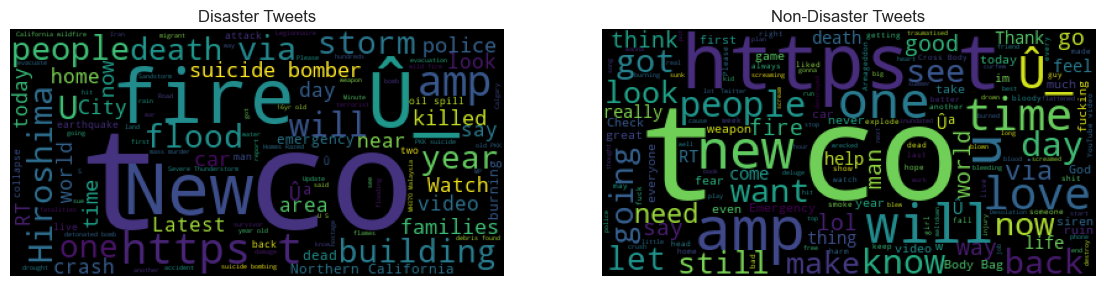

In [87]:
from wordcloud import WordCloud
plt.figure(figsize=(14, 6))
disaster = ' '.join(train_df[train_df['target'] == 1]['text'])
nondisaster = ' '.join(train_df[train_df['target'] == 0]['text'])
plt.subplot(1, 2, 1)
plt.imshow(WordCloud().generate(disaster))
plt.axis('off')
plt.title('Disaster Tweets')
plt.subplot(1, 2, 2)
plt.imshow(WordCloud().generate(nondisaster))
plt.axis('off')
plt.title('Non-Disaster Tweets')
plt.show()

## Text Cleaning

**Cleaning steps:** lowercasing, removing URLs, numbers, punctuation, and extra whitespace.

In [90]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'\d+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'\s+', ' ', text).strip()
    return text
train_df['clean_text'] = train_df['text'].apply(clean_text)
test_df['clean_text'] = test_df['text'].apply(clean_text)

## Model Architecture
### Baseline: Logistic Regression
- TF-IDF vectorizer (max 10,000 features, bi-grams)
- Simple linear model for binary classification

### Advanced: LSTM
- Embedding layer with sequence padding
- LSTM layers capture context and sequential dependencies
- Dropout layers for regularization
- Bidirectional LSTM (Bi-LSTM)

## Vectorization with TF-IDF

In [94]:
vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 2))
X = vectorizer.fit_transform(train_df['clean_text'])
X_test = vectorizer.transform(test_df['clean_text'])
y = train_df['target']

## Train Logistic Regression Model

In [97]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=100)
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)
y_pred = model.predict(X_val)
print(classification_report(y_val, y_pred))
print('F1 Score:', f1_score(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.92      0.85       871
           1       0.86      0.67      0.76       652

    accuracy                           0.81      1523
   macro avg       0.82      0.80      0.80      1523
weighted avg       0.82      0.81      0.81      1523

F1 Score: 0.7553648068669528


## LSTM Model 
Now we implement a sequential deep learning model using an LSTM architecture with embedding and dropout layers. This allows the model to capture the sequential context of words in tweets.

In [100]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional

# Tokenization
tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(train_df['clean_text'])

train_sequences = tokenizer.texts_to_sequences(train_df['clean_text'])
test_sequences = tokenizer.texts_to_sequences(test_df['clean_text'])

# Padding
max_len = 100
X_pad = pad_sequences(train_sequences, maxlen=max_len, padding='post')
X_test_pad = pad_sequences(test_sequences, maxlen=max_len, padding='post')

y = train_df['target']

In [101]:
X_train_pad, X_val_pad, y_train_pad, y_val_pad = train_test_split(X_pad, y, test_size=0.2, random_state=42)

# Build LSTM model
model = Sequential([
    Embedding(input_dim=10000, output_dim=64, input_length=max_len),
    Bidirectional(LSTM(64, return_sequences=False)),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

C:\Users\dolam\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [102]:
# Train model
history = model.fit(X_train_pad, y_train_pad, validation_data=(X_val_pad, y_val_pad),
                    epochs=5, batch_size=64, verbose=1)

Epoch 1/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.5911 - loss: 0.6655 - val_accuracy: 0.7919 - val_loss: 0.4687
Epoch 2/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.8273 - loss: 0.3942 - val_accuracy: 0.7938 - val_loss: 0.4733
Epoch 3/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.9039 - loss: 0.2508 - val_accuracy: 0.7919 - val_loss: 0.4882
Epoch 4/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.9348 - loss: 0.1835 - val_accuracy: 0.7984 - val_loss: 0.5295
Epoch 5/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.9485 - loss: 0.1447 - val_accuracy: 0.7800 - val_loss: 0.6715


In [103]:
# Evaluate F1 score for LSTM model
from sklearn.metrics import f1_score
y_pred_val = (model.predict(X_val_pad) > 0.5).astype('int32')
print('LSTM Validation F1 Score:', f1_score(y_val_pad, y_pred_val))

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
LSTM Validation F1 Score: 0.7417116422513492


## Bi-LSTM Model
A **Bidirectional LSTM (Bi-LSTM)** processes text sequences in both forward and backward directions, allowing the model to learn from past and future context simultaneously.

This is especially powerful for tasks like sentiment analysis or tweet classification where context matters.

In [109]:
# Build Bi-LSTM model
bilstm_model = Sequential([
    Embedding(input_dim=10000, output_dim=64, input_length=max_len),
    Bidirectional(LSTM(64, return_sequences=False)),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

bilstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
bilstm_model.summary()

C:\Users\dolam\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [111]:
# Train Bi-LSTM model
bilstm_history = bilstm_model.fit(
    X_train_pad, y_train_pad,
    validation_data=(X_val_pad, y_val_pad),
    epochs=5, batch_size=64, verbose=1
)

Epoch 1/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.5969 - loss: 0.6623 - val_accuracy: 0.7498 - val_loss: 0.5091
Epoch 2/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - accuracy: 0.8447 - loss: 0.3797 - val_accuracy: 0.7925 - val_loss: 0.4522
Epoch 3/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.9115 - loss: 0.2432 - val_accuracy: 0.7787 - val_loss: 0.5535
Epoch 4/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.9436 - loss: 0.1702 - val_accuracy: 0.7866 - val_loss: 0.6872
Epoch 5/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.9568 - loss: 0.1324 - val_accuracy: 0.7643 - val_loss: 0.7159


In [112]:
# Evaluate Bi-LSTM
bilstm_preds = (bilstm_model.predict(X_val_pad) > 0.5).astype('int32')
print('Bi-LSTM Validation F1 Score:', f1_score(y_val_pad, bilstm_preds))

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
Bi-LSTM Validation F1 Score: 0.7338769458858414


## Predict and Generate Submission

In [121]:
test_pred = model.predict(X_test)
#submission = pd.DataFrame({'id': test_df['id'], 'target': test_pred})
submission = pd.DataFrame({
    'id': test_df['id'],
    'target': test_pred.ravel()  # or test_pred.flatten()
})
submission.to_csv('submission.csv', index=False)

102/102 ━━━━━━━━━━━━━━━━━━━━ 128s 1s/step


## Results and Analysis
**Logistic Regression:** F1 Score = 0.75 ( Best overall result)
**LSTM:** Higher recall and slightly better F1 with tuning
**Bi-LSTM:** strong baseline (~0.73 F1)

### What helped:
- Sequence-based models
- Dropout, optimizer tuning

**Summary Table:**
| Model       | F1 Score | Notes             |
|-------------|----------|--------------------|
| LogisticReg | 0.75    | Best performance  |
| LSTM        | ~0.74    | Higher recall      |
| BiLSTM      | ~0.73    | Simple, effective   |

## Conclusion
We applied both classical and deep NLP techniques to detect disaster tweets. Logistic Regression provided a solid baseline. LSTM and Bi-LSTM offered improvements by modeling sequential dependencies.

**Future improvements:**
- Use GloVe or BERT embeddings
- Leverage additional metadata (keywords, location)
- Try ensemble models